# 快速上手飞浆

深度学习任务一般分为以下几个核心步骤：

1. 数据集定义与加载
2. 模型组网
3. 模型训练与评估
4. 模型推理

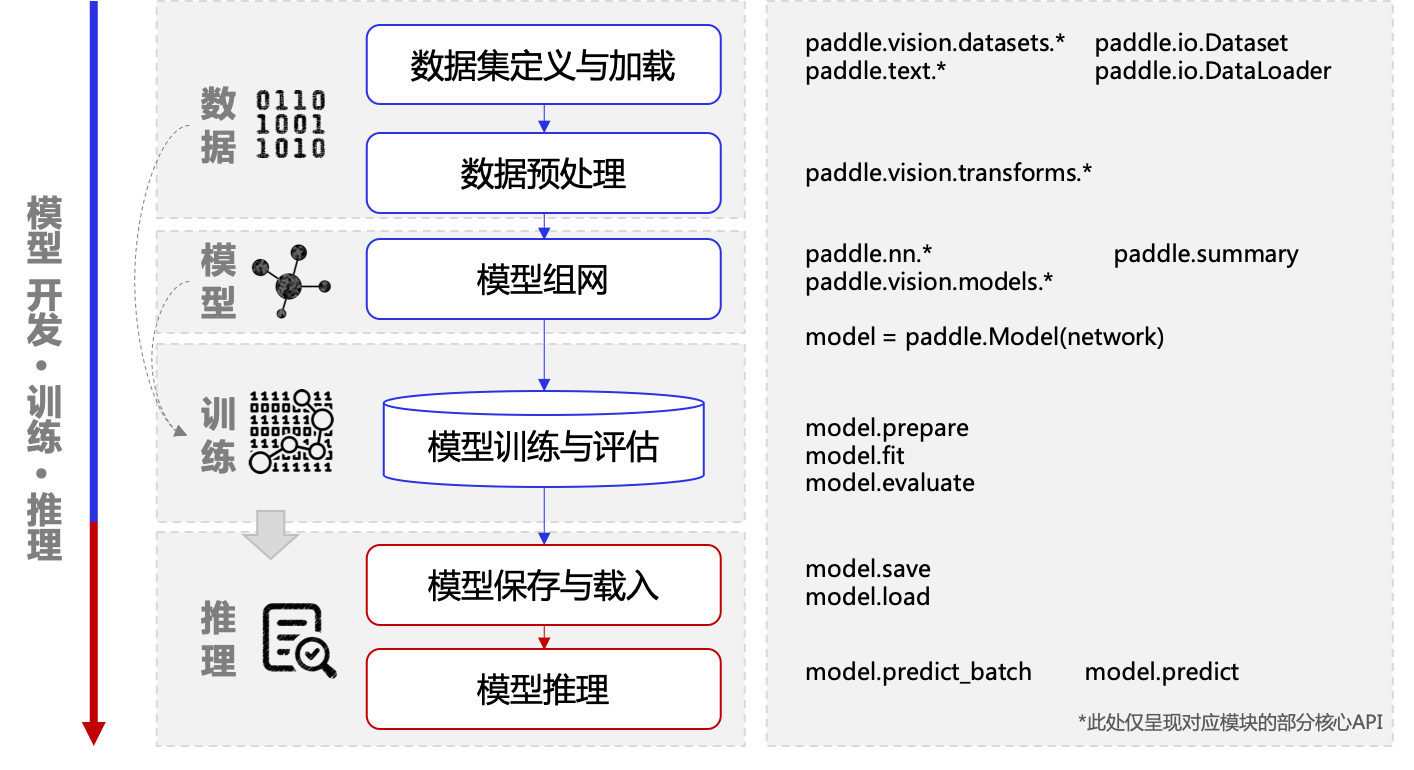

## 数据集定义与加载

- paddle.vision.datasets 内置了计算机视觉领域常见的数据集，如MNIST, Cifar10, Cifar100, FashionMNIST, VOC2021等
- paddle.text 内置了自然语言处理NLP领域常见的数据集
- paddle.io.Dataset和paddle.io.DataLoader 自定义数据集与加载功能
- paddle.vision.transforms 提供常用的图像变换操作，如图像翻转、裁剪、调整亮度等，可实现数据增强，以增加训练样本的多样性，提升模型的泛化能力

In [3]:
import paddle
from paddle.vision.transforms import Normalize

# 对图像进行归一化处理，可以加快模型训练的收敛速度
# CHW指图像格式需为 [C通道数，H图像高度，W图像宽度]
transform = Normalize(mean=[127.5], std=[127.5], data_format='CHW')

# 加载飞浆内置的手写数字识别MNIST数据集
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)

# 查看数据集里的图像数量
print('{} images in train_dataset, {} images in test_dataset'.format(len(train_dataset), len(test_dataset)))

60000 images in train_dataset, 10000 images in test_dataset


## 模型组网

- 飞浆的模型组网有多种方式，既可以直接使用内置的模型，也可以自定义组网
- paddle.vision.models 内置里CV领域的一些经典模型
- 通过paddle.nn.Layer和paddle.nn.Sequential可以方便灵活组建自定义的神经网络
- paddle.summary 方便查看网络的基础结构和参数信息

In [4]:
# 使用飞浆内置的LeNet模型，并定义分类的类别数
lenet = paddle.vision.models.LeNet(num_classes=10)

# 查看网络的基础结构和参数信息
paddle.summary(lenet, (1, 1, 28, 28))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1       [[1, 1, 28, 28]]      [1, 6, 28, 28]          60       
    ReLU-1        [[1, 6, 28, 28]]      [1, 6, 28, 28]           0       
  MaxPool2D-1     [[1, 6, 28, 28]]      [1, 6, 14, 14]           0       
   Conv2D-2       [[1, 6, 14, 14]]     [1, 16, 10, 10]         2,416     
    ReLU-2       [[1, 16, 10, 10]]     [1, 16, 10, 10]           0       
  MaxPool2D-2    [[1, 16, 10, 10]]      [1, 16, 5, 5]            0       
   Linear-1          [[1, 400]]            [1, 120]           48,120     
   Linear-2          [[1, 120]]            [1, 84]            10,164     
   Linear-3          [[1, 84]]             [1, 10]              850      
Total params: 61,610
Trainable params: 61,610
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward

{'total_params': 61610, 'trainable_params': 61610}

## 模型训练与评估

- 使用paddle.Model封装模型，将网络结构组合成可快速使用飞浆高层API进行训练、评估、推理的实例，方便后续操作。
- 使用paddle.Model.prepare完成训练的配置准备工作，包括优化器、损失函数和评价指标等。
    - paddle.optimizer提供了优化器算法相关API
    - paddle.nn Loss层提供了损失函数相关API
    - paddle.metric 提供了评价指标相关API
- 使用paddle.Model.fit配置循环参数并启动训练，配置参数包括指定训练等数据源、训练等批大小、训练轮数等，执行后将自动完成模型等训练循环。

In [5]:
# 封装模型，便于后续的训练、评估和推理
model = paddle.Model(lenet)

# 模型训练配置：优化器、损失函数、评价指标
model.prepare(paddle.optimizer.Adam(parameters=model.parameters()),
             paddle.nn.CrossEntropyLoss(),
             paddle.metric.Accuracy())

# 开始训练
model.fit(train_dataset, epochs=5, batch_size=64, verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/5
step 938/938 [==============================] - loss: 0.0405 - acc: 0.9476 - 9ms/step          
Epoch 2/5
step 938/938 [==============================] - loss: 0.0204 - acc: 0.9794 - 9ms/step          
Epoch 3/5
step 938/938 [==============================] - loss: 0.0175 - acc: 0.9835 - 9ms/step          
Epoch 4/5
step 938/938 [==============================] - loss: 0.0015 - acc: 0.9854 - 9ms/step          
Epoch 5/5
step 938/938 [==============================] - loss: 0.0364 - acc: 0.9878 - 9ms/step          


In [7]:
# 用测试数据集进行模型评估
model.evaluate(test_dataset, batch_size=64, verbose=1)

Eval begin...
step 157/157 [==============================] - loss: 3.0395e-04 - acc: 0.9848 - 4ms/step         
Eval samples: 10000


{'loss': [0.0003039487], 'acc': 0.9848}

## 模型推理

- 模型训练完成后，通常需要将训练好的模型参数和优化器参数等信息，持久化保存到参数文件中，便于后续执行推理验证
- 调用paddle.Model.save保存模型，根据自定的模型文件名称，默认生成两个文件
    - xxx.pdparams 模型参数
    - xxx.pdopt 优化器参数
- 通过paddle.Model.predict_batch进行推理预测

In [8]:
# 保存模型
model.save('../models/mnist')

In [9]:
# 加载模型
model.load('../models/mnist')

In [56]:
import numpy as np

np.random.randint(1, 10)

4

In [57]:
import numpy as np

# 从测试集中随机取一张图片
i = np.random.randint(0, len(test_dataset))
img, label = test_dataset[i]

# 将图片shape从1*28*28变为1*1*28*28，增加一个batch维度，以匹配模型输入的格式要求

img_batch = np.expand_dims(img.astype('float32'), axis=0)

# 执行推理并打印结果，此处返回一个list，取出其中数据获得预测结果
out = model.predict_batch(img_batch)[0]
pred_label = out.argmax()
print('true label is {}, predict label is {}'.format(label[0], pred_label))

true label is 9, predict label is 9


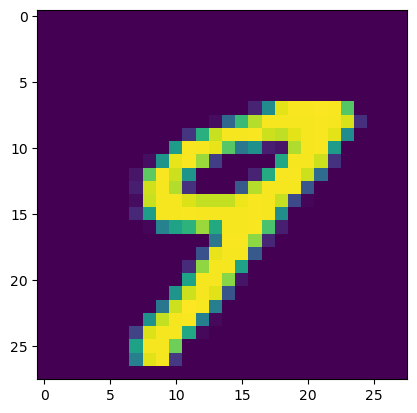

In [58]:
# 可视化图片
from matplotlib import pyplot as plt
plt.imshow(img[0])